# Comparison between `sklearn.pipeline.Pipeline` and the `mlght` framework
The functionalities of `mlght` can be fully and easily implemented by the `sklearn.pipeline.Pipeline` utility. This notebook tests the consistency between the two approaches.

## Imports, constants and general utilities

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import root_mean_squared_error

In [2]:
# Constants
n_cv_splits = 5
n_estimators = 10

In [3]:
class DataPreparation:
    @staticmethod
    def prepare_data(sample_size = 1000):
        X = pd.DataFrame(np.random.rand(sample_size, 3), columns=['F1', 'F2', 'F3'])
        y = pd.DataFrame(2 * X['F1'] + 5 * X['F3'] + np.random.normal(0, 0.1, sample_size), columns=['Target'])
        return X, y

class EvaluationFramework:
    @staticmethod
    def evaluate_results(ytrue, ypred, eval_case):
        fig, ax = plt.subplots(figsize = (6.5, 2.5))
        ax.scatter(ytrue, ypred, c = "tab:blue", s = 20, alpha = 0.75)
        ax.grid(lw = 0.5, ls = ":")
        ax.set_xlabel("True values", fontsize = 14)
        ax.set_ylabel("Predictions", fontsize = 14)
        ax.set_title(f"{eval_case}", fontsize = 14, pad = 10)
        plt.show()

## `Pipeline`
### Prepare data

In [4]:
X, y = DataPreparation.prepare_data()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.25)

### Set the base estimator and the bagging regressor

In [5]:
base_estimator = LinearRegression()

xscaler = StandardScaler()
yscaler = StandardScaler()

bagging_model = BaggingRegressor(
    estimator = base_estimator,
    n_estimators = n_estimators, 
    max_samples = 0.66
)

### Pipe the scalers and the regressor

In [6]:
x_pipeline = Pipeline(steps=[
    ('xscaler', xscaler), 
    ('bagging_regressor', bagging_model)
])

trainer_equivalent = TransformedTargetRegressor(
    regressor = x_pipeline,
    transformer = yscaler
)

### Implement the k-fold cross-validation

In [7]:
cv_protocol = KFold(n_splits = n_cv_splits, shuffle = True)
cv_scores = cross_val_score(
    estimator = trainer_equivalent,
    X = Xtrain,
    y = ytrain,
    scoring = 'neg_root_mean_squared_error',
    cv = cv_protocol,
    n_jobs = -1
)

rmse_scores = -cv_scores
avg_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)

print("Cross-Validation Results")
print(f"Average RMSE: {avg_rmse:.4f} ± {std_rmse:.4f}")

Cross-Validation Results
Average RMSE: 0.1037 ± 0.0031


### Train the piped model

In [8]:
trainer_equivalent.fit(Xtrain, ytrain['Target'])

,regressor,Pipeline(step...mples=0.66))])
,transformer,StandardScaler()
,func,None
,inverse_func,None
,check_inverse,True
,copy,True
,with_mean,True
,with_std,True
,estimator,LinearRegression()
,n_estimators,10
,max_samples,0.66


### Evaluate


Training Complete.
Prediction made on X_test.
RMSE (mimicking Trainer.evaluate): 0.1025


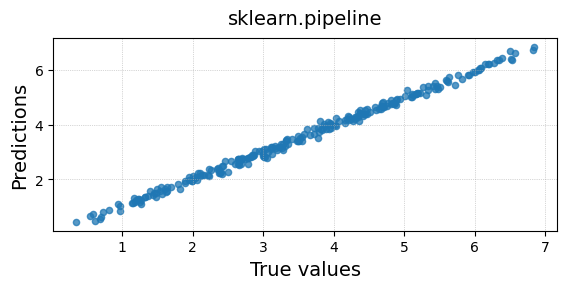

In [9]:
ypred = trainer_equivalent.predict(Xtest)
ypred = pd.DataFrame(ypred, columns = ytest.columns, index = ytest.index)

rmse = root_mean_squared_error(ytest, ypred)
print(f"\nTraining Complete.")
print(f"Prediction made on X_test.")
print(f"RMSE (mimicking Trainer.evaluate): {rmse:.4f}")

EvaluationFramework.evaluate_results(ytest, ypred, "sklearn.pipeline")

## `mlght`

In [10]:
from mlght.core.training import Trainer
from mlght.core.scalers import ResettableStandardScaler
from tqdm.notebook import tqdm

In [11]:
trainer = Trainer(
    base_estimator = LinearRegression,
    estimator_name = "LinearRegression",
    estimator_kwargs = dict(),
    n_cv_splits = n_cv_splits,
    n_estimators = n_estimators,
    input_normalizer = ResettableStandardScaler,
    target_normalizer = ResettableStandardScaler,
    verbose = False,
    pbar_module = tqdm
)

In [12]:
trainer.run_kfold_cv(Xtrain, ytrain)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

+----------+-----------------+
| Metric   | Target          |
+==========+=================+
| RMSE     | 0.1032 ± 0.0041 |
+----------+-----------------+


In [13]:
trainer.fit(Xtrain, ytrain)

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
ypred = trainer.predict(Xtest, columns = ytest.columns, index = ytest.index)
_ = trainer.evaluate(ytest, ypred, print_metrics = True)


------------
Evaluation: 

+------+----------+
|      |   Target |
+======+==========+
| RMSE | 0.102351 |
+------+----------+


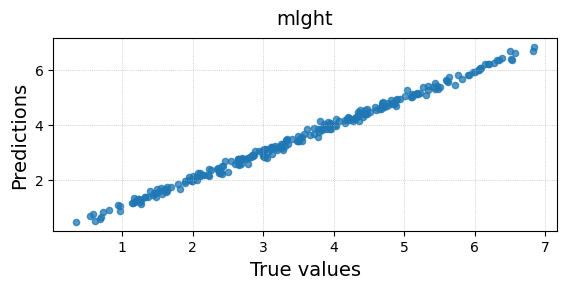

In [15]:
EvaluationFramework.evaluate_results(ytest, ypred, "mlght")